In [67]:
from data_pipeline.np_dataset import NpDataset
import input_mapping.models_torch as models_torch
from data_pipeline.image_transforms import get_transforms

from data_pipeline.data_package import DataPackage





from PIL import Image
from pydicom import dcmread
import torch
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
import numpy as np

from ai_backend.loggers.model_logger import is_min
from uuid import uuid4
import torch.nn as nn
from torch.optim import Adam
import torch
import json
import os
import re
import tqdm
from ai_backend.evaluators.metrics.multi_label_metrics import  multi_label_f_beta, multi_label_confusion_matrix, multi_label_accuracy, multi_label_precision, multi_label_recal
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd



In [68]:
#checkpoint 1
augmentations = transforms.Compose([
                transforms.RandomRotation(10),
                transforms.RandomHorizontalFlip(p=0.6),
                transforms.RandomVerticalFlip(p=0.5)
            ])

In [69]:
#create np datasets for training, validation and testing
read_dicom = lambda x: dcmread(x).pixel_array
dicom_file_reader = lambda x: Image.fromarray(read_dicom(x)).convert('RGB')
default_file_reader = lambda x: Image.open(x).convert('RGB')


In [70]:
model_key = 'resnet18'
transform_type = 'ben'
transforms_config = models_torch.model_dict[model_key]['transforms_config']
transform = get_transforms(transform_name = transform_type, transforms_config = transforms_config)
labels_to_encode = np.array(["Age-related Macular Degeneration", "Best Disease", "Bietti crystalline dystrophy",
                              "cataract", "Cone Dystrophie or Cone-rod Dystrophie", "Diabetic Retinopathy",
                              "glaucoma", "Maculopathy", "Myopia", "Normal", "Retinitis Pigmentosa", "Stargardt Disease"])

In [71]:
def convert_package_to_dataset(package, augmentations=None):
    file_reader = dicom_file_reader if package.data_source_name == 'UKB' else default_file_reader
    dataset = NpDataset(file_paths=package.get_data(), labels=package.get_labels(),
                         file_reader=file_reader, transform=transform, augmentation_transform=augmentations)
    return dataset

def convert_package_list_to_dataset(package_list, augmentations=None):
    datasets = []
    for package in package_list:
        dataset = convert_package_to_dataset(package)
        datasets.append(dataset)
    return datasets

In [72]:
#list the saved directories and load the datapackages
dataset_path = 'datasets/2024-05-17_12-13-57'
train_packages_path = f'{dataset_path}/train'
val_packages_path = f'{dataset_path}/val'
test_packages_path = f'{dataset_path}/test'
package_paths = [train_packages_path, val_packages_path, test_packages_path]
train_packages = []
val_packages = []
test_packages = []
all_packages = [train_packages, val_packages, test_packages]

for path, package_list  in zip(package_paths, all_packages):
    files = os.listdir(path)
    for file in files:
        package = DataPackage.load(f'{path}/{file}')
        package_list.append(package)
#convert to np datasets
train_datasets = convert_package_list_to_dataset(train_packages, augmentations=augmentations)
val_datasets = convert_package_list_to_dataset(val_packages)
test_datasets = convert_package_list_to_dataset(test_packages)


In [73]:
for i, dataset in  enumerate(train_datasets):
    dataset.balance_augmentation()

In [74]:
#concat the datasets
train_dataset = ConcatDataset(train_datasets)
validation_dataset = ConcatDataset(val_datasets)
test_dataset = ConcatDataset(test_datasets)

#create data loaders
num_workers = 8
validation_loader = DataLoader(validation_dataset, batch_size=512, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=512, num_workers=num_workers)

In [75]:
# create model
model = models_torch.get_model(model_name=model_key, num_classes=len(labels_to_encode))


/home/efarjall/miniconda3/envs/ird/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/efarjall/miniconda3/envs/ird/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [76]:
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=lr)

In [77]:
#add dropout forward hooks to the model
for name, module in model.named_modules():
    re_pattern = re.compile(r'^layer\d+$')
    if re_pattern.match(name) is not None:
        print('Adding forward hook for:', name)
        module.register_forward_hook(lambda module, input,
                                      output: torch.nn.functional.dropout2d(output, p=0.2, training=module.training))

Adding forward hook for: layer1
Adding forward hook for: layer2
Adding forward hook for: layer3
Adding forward hook for: layer4


In [78]:
model_id = '81b2c970-7f81-4f06-95c8-19977fcd7020'

In [79]:
#train the model
dataset_name = '2024-05-17_12-13-57'
best_model_save_folder = f'models/{model_key}/{model_id}'
best_model_save_path = f'{best_model_save_folder}/weights.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')




In [80]:
#load the best model
model.load_state_dict(torch.load(best_model_save_path))

<All keys matched successfully>

In [81]:
evaluations_save_folder = f'{best_model_save_folder}/evaluations'
os.makedirs(evaluations_save_folder, exist_ok=True)

In [82]:
#get the predictions for the model
y_true_validation = []
y_pred_validation = []
model.to(device)
model.eval()
with torch.no_grad():
    for inputs, labels in validation_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        y_true_validation.append(labels.detach().clone())
        y_pred_validation.append(outputs.detach().clone())
y_true_validation = torch.cat(y_true_validation, dim=0).cpu()
y_pred_validation = torch.cat(y_pred_validation, dim=0).cpu()

In [ ]:
#find the best threshold for each label
#turn off optuna warnings
step_size = 0.01
iterations = 1/step_size
#set the verbosity to error

best_thresholds = []

for i in range(len(labels_to_encode)):
    best_thresholds.append(0)
    best_score = 0
    #todo fix the max function
    for j in range(int(iterations)):
        threshold = j*step_size
        f1_score = multi_label_f_beta(y_true_validation, y_pred_validation, beta=1.0, averaging_type=None, threshold=threshold)
        if f1_score[i] > best_score:
            best_score = f1_score[i]
            best_thresholds[i] = threshold
    print('Best thresholds found for class', labels_to_encode[i], 'at', best_thresholds[i], 'with a score of', best_score)

best_thresholds = torch.Tensor(best_thresholds)



In [84]:
print('Best thresholds:', best_thresholds.tolist())


Best thresholds: [0.5899999737739563, 0.9399999976158142, 0.07999999821186066, 0.9100000262260437, 0.5199999809265137, 0.7599999904632568, 0.8199999928474426, 0.5299999713897705, 0.6399999856948853, 0.2199999988079071, 0.44999998807907104, 0.23000000417232513]


In [85]:
#save the best thresholds in the model configuration
#load the model configuration
model_config = {}
with open(f'{best_model_save_folder}/model_config.json', 'r') as f:
    model_config = json.load(f)
model_config['best_thresholds'] = best_thresholds.tolist()
with open(f'{best_model_save_folder}/model_config.json', 'w') as f:
    json.dump(model_config, f)

In [86]:
#execute the model on the test set
y_true = []
y_pred = []
x = []
model.to(device)
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        y_true.append(labels.detach().clone())
        y_pred.append(outputs.detach().clone())
        x.append(inputs.detach().clone())
y_true = torch.cat(y_true, dim=0).cpu()
y_pred = torch.cat(y_pred, dim=0).cpu()
X_test = torch.cat(x, dim=0).cpu()

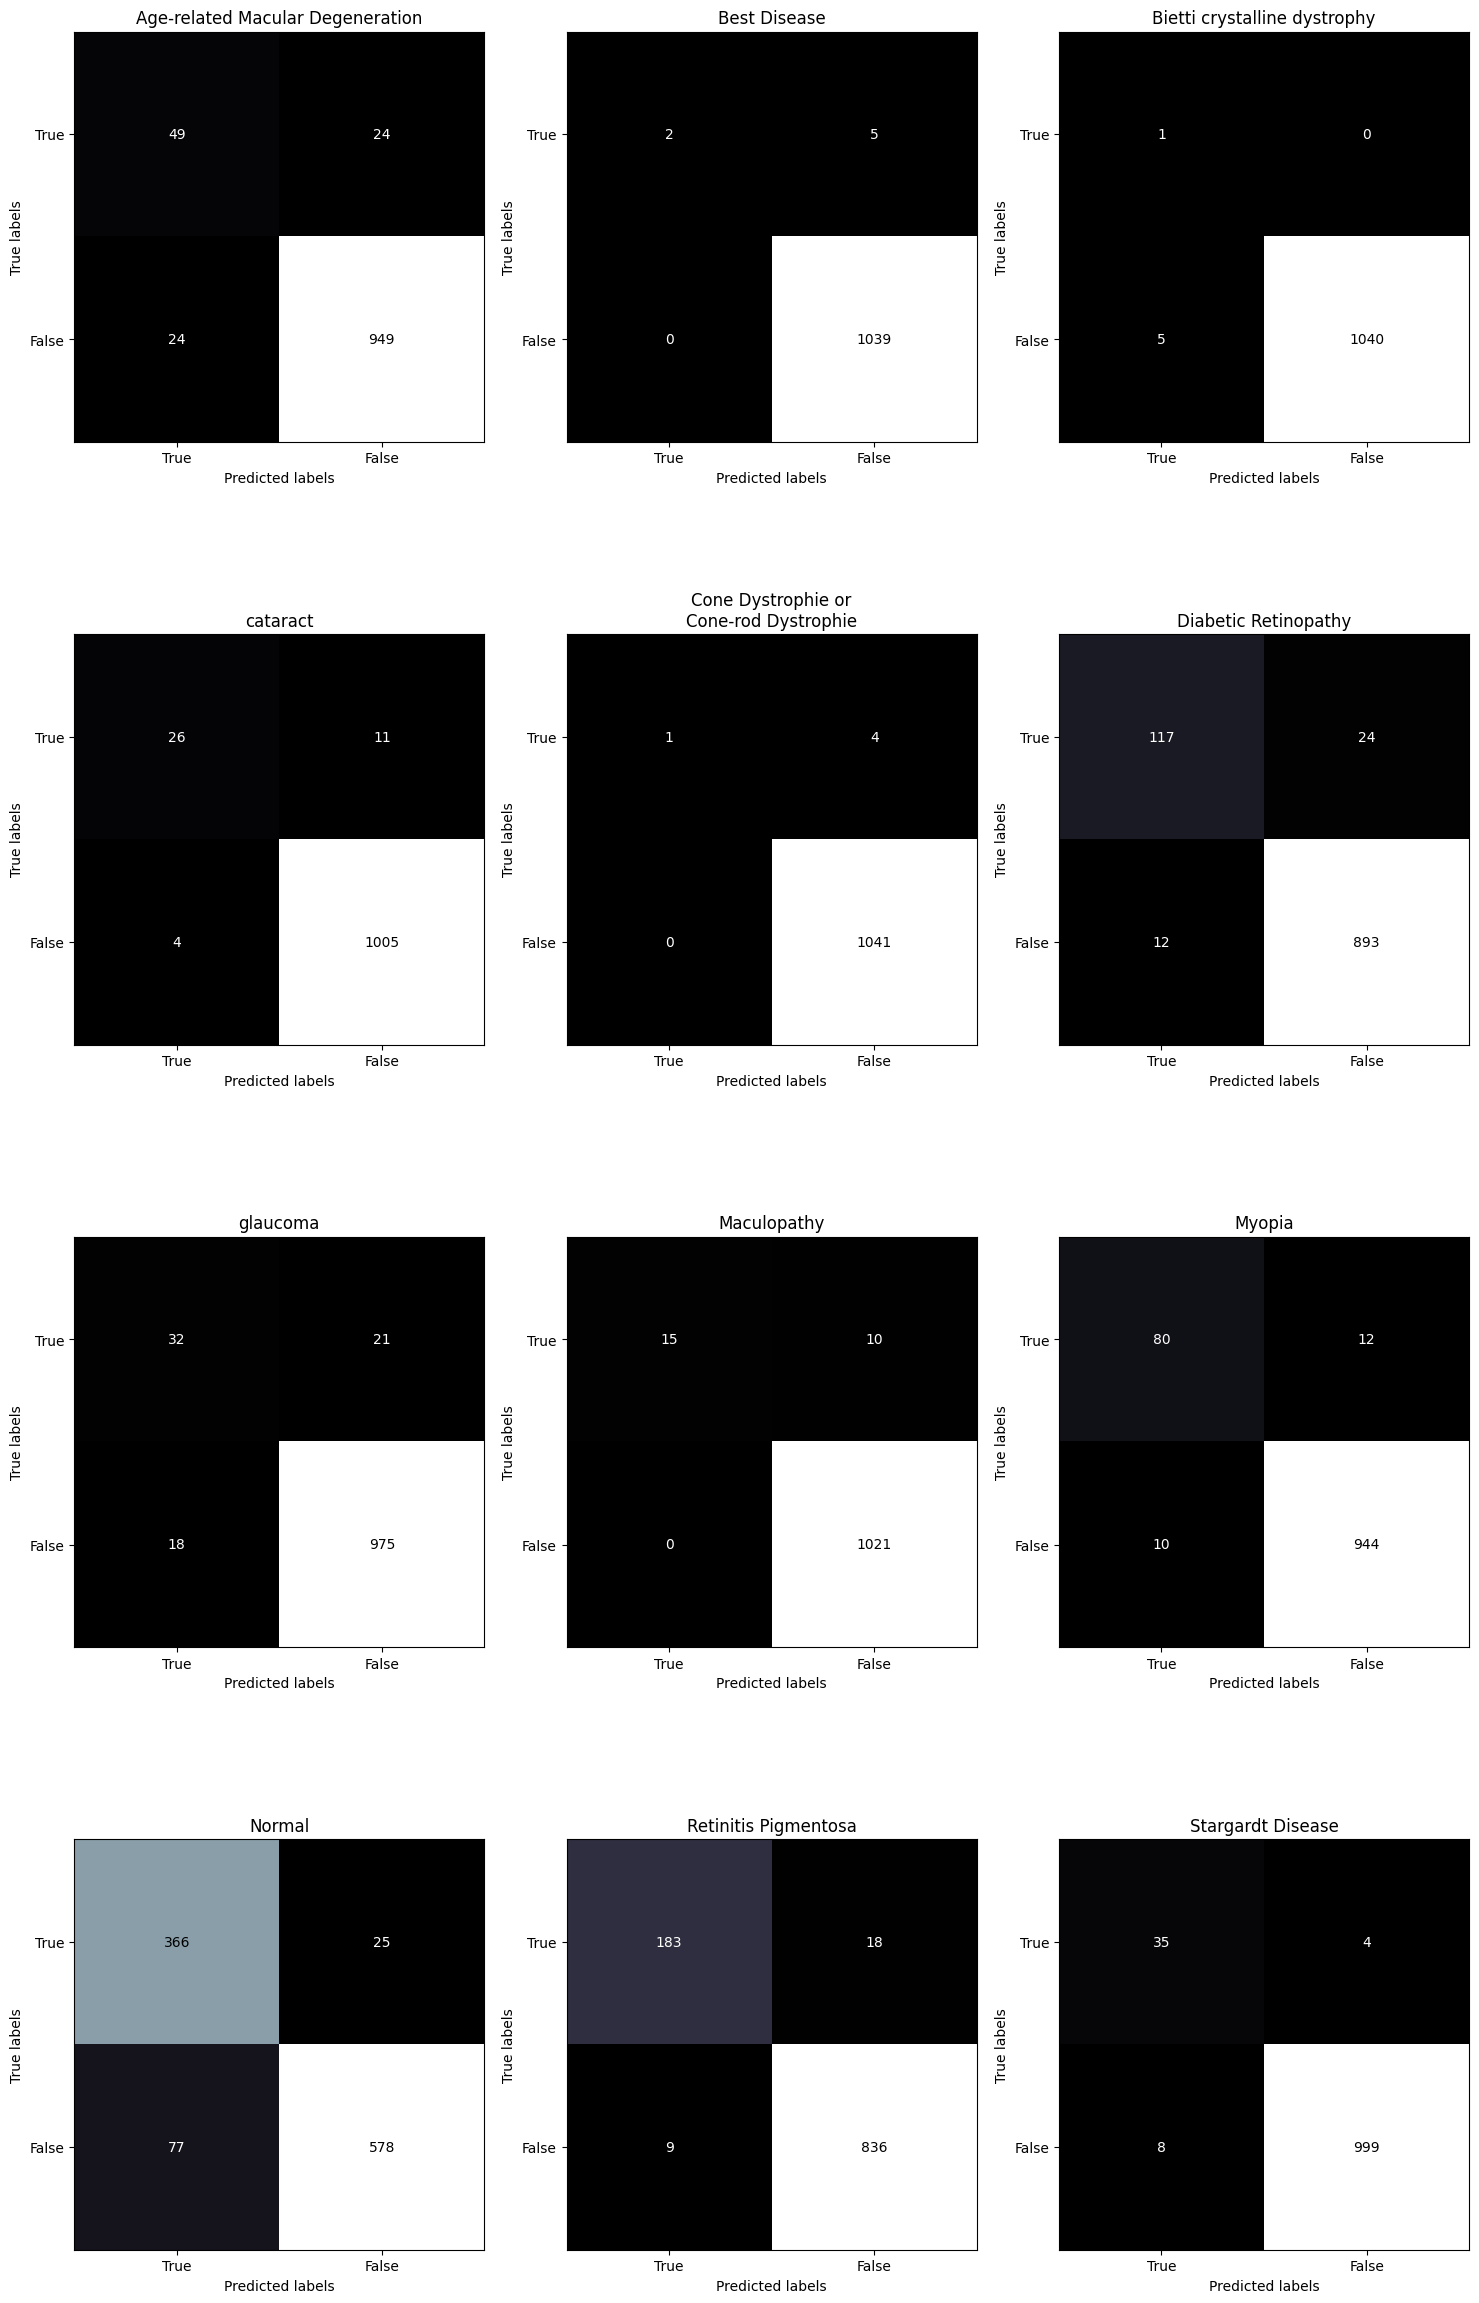

In [87]:
y_pred_cm = torch.sigmoid(y_pred) >best_thresholds
#calculate the confusion matrices on the test set
confusion_matrices = multilabel_confusion_matrix(y_true, y_pred_cm)
flipped_confusion_matrices = np.flip(confusion_matrices, axis=-1)
flipped_confusion_matrices = np.flip(flipped_confusion_matrices, axis=-2)
#plot the confusion matrices, one for each class, 3 per row
n_cols = 3
n_rows = int(np.ceil(len(labels_to_encode) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 30))
axes = axes.flatten()
for i, ax in enumerate(axes):
    #use the confusion matrix to plot the confusion matrix
    cm = confusion_matrices[i]
    disp = ConfusionMatrixDisplay(confusion_matrix=flipped_confusion_matrices[i], display_labels=['True', 'False'])
    #turn off color bar

    disp.plot(ax=ax, colorbar=False, cmap='bone')
    title = labels_to_encode[i]
    #split the title into multiple lines if it is too long
    if title.count(' ') > 2:
        #split every 3rd space
        title = title.split(' ')
        title = [' '.join(title[i:i+3]) for i in range(0, len(title), 3)]
        title = '\n'.join(title)
    ax.set_title(title)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
#save the figure
plt.savefig(f'{evaluations_save_folder}/confusion_matrices.png')

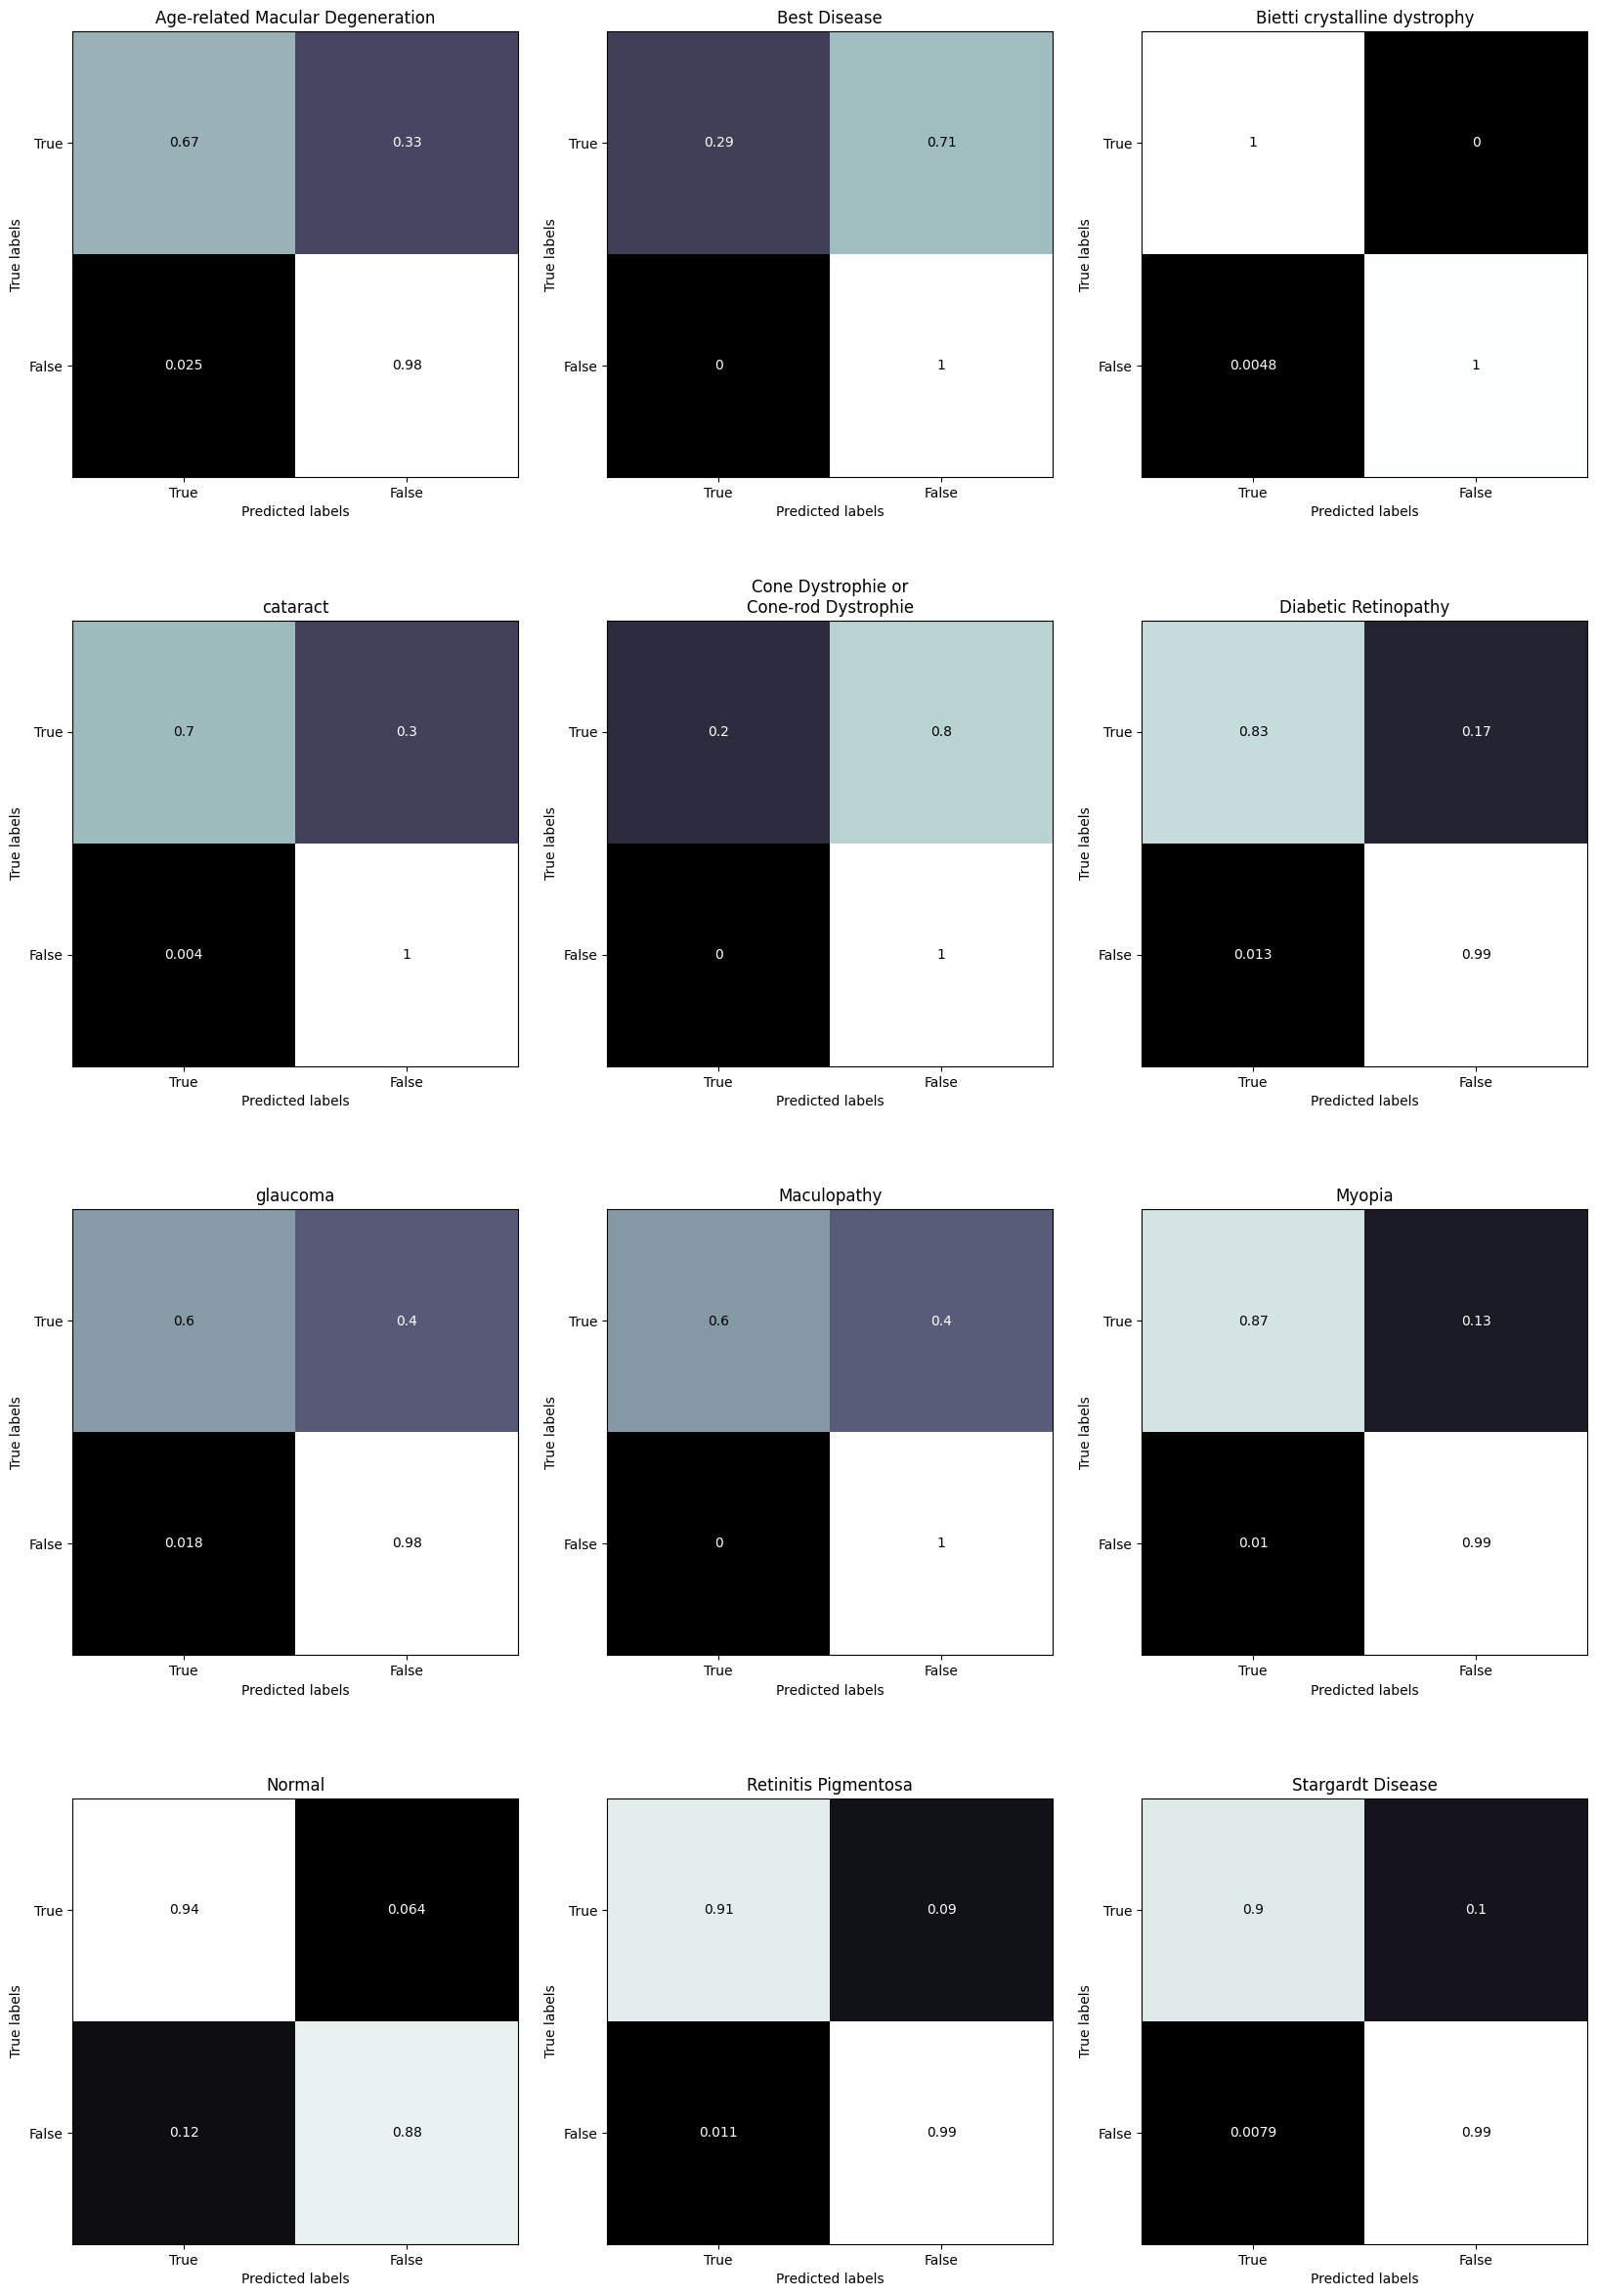

In [88]:
#plot the same confusion matrices with the row normalised values
cm_normalizer = confusion_matrices.sum(axis=2)#[:,np.newaxis]
#add a new dimension to the normalizer
cm_normalizer = cm_normalizer[:,np.newaxis]
#add a copy of the normalizer to the normalizer

#cm_normalizer = np.concatenate([cm_normalizer, cm_normalizer], axis=0)
reversed_normalizer = np.flip(cm_normalizer, axis=-1)
cm_normalizer=np.concatenate([cm_normalizer, reversed_normalizer], axis=1)
#flip the normalizer
cm_normalizer[:,:,1] = cm_normalizer[:,0,:]
normalized_cms = confusion_matrices / cm_normalizer
flipped_normalised_cms = np.flip(np.flip(normalized_cms, axis=-1), axis=-2)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))
axes = axes.flatten()
for i, ax in enumerate(axes):
    #use the confusion matrix to plot the confusion matrix
    cm = confusion_matrices[i]
    disp = ConfusionMatrixDisplay(confusion_matrix=flipped_normalised_cms[i], display_labels=['True', 'False'])
    #turn off color bar

    disp.plot(ax=ax, colorbar=False, cmap='bone')
    title = labels_to_encode[i]
    #split the title into multiple lines if it is too long
    if title.count(' ') > 2:
        #split every 3rd space
        title = title.split(' ')
        title = [' '.join(title[i:i+3]) for i in range(0, len(title), 3)]
        title = '\n'.join(title)
    ax.set_title(title)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    #save the figure
plt.savefig(f'{evaluations_save_folder}/confusion_matrices_normalized.png')

In [89]:
#show how many tp, fp, tn, fn there are in total
tp = confusion_matrices[:, 1, 1]
fp = confusion_matrices[:, 0, 1]
tn = confusion_matrices[:, 0, 0]
fn = confusion_matrices[:, 1, 0]
print(f'TP: {tp.sum()}')
print(f'FP: {fp.sum()}')
print(f'TN: {tn.sum()}')
print(f'FN: {fn.sum()}')
print('-----------------------------------')
best_thresholds = np.array(best_thresholds)
#calculate the precision, recall, accuracy and f1 score
precision_macro = multi_label_precision(y_true, y_pred, threshold=best_thresholds, averaging_type='macro')
recall_macro = multi_label_recal(y_true, y_pred, threshold=best_thresholds, averaging_type='macro')
accuracy_macro = multi_label_accuracy(y_true, y_pred, threshold=best_thresholds, averaging_type='macro')
f1_macro = multi_label_f_beta(y_true, y_pred, beta=1.0, averaging_type='macro', threshold=best_thresholds)
#do the same for the micro scores
precision_micro = multi_label_precision(y_true, y_pred, threshold=best_thresholds, averaging_type='micro')
recall_micro = multi_label_recal(y_true, y_pred, threshold=best_thresholds, averaging_type='micro')
accuracy_micro = multi_label_accuracy(y_true, y_pred, threshold=best_thresholds, averaging_type='micro')
f1_micro = multi_label_f_beta(y_true, y_pred, beta=1.0, averaging_type='micro', threshold=best_thresholds)

#save the evaluation metrics in a dictionary
evaluation_metrics = {
    'precision_macro': precision_macro,
    'recall_macro': recall_macro,
    'accuracy_macro': accuracy_macro,
    'f1_macro': f1_macro,
    'precision_micro': precision_micro,
    'recall_micro': recall_micro,
    'accuracy_micro': accuracy_micro,
    'f1_micro': f1_micro
}
#save the evaluation metrics
with open(f'{evaluations_save_folder}/evaluation_metrics.json', 'w') as f:
    json.dump(evaluation_metrics, f)

TP: 907
FP: 167
TN: 11320
FN: 158
-----------------------------------


In [90]:
#print the evaluation metrics
for key, value in evaluation_metrics.items():
    print(key,':', round(value,2))

precision_macro : 0.81
recall_macro : 0.71
accuracy_macro : 0.97
f1_macro : 0.76
precision_micro : 0.84
recall_micro : 0.85
accuracy_micro : 0.97
f1_micro : 0.85


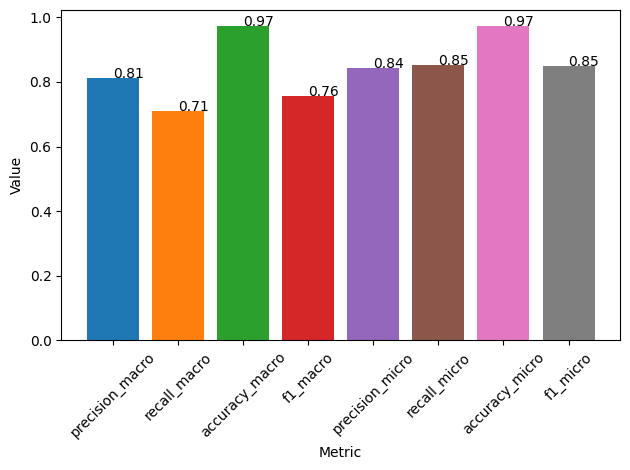

In [91]:
#plot the evaluation metrics
plt.figure()
for metric_name, metric_value in evaluation_metrics.items():
    plt.bar(metric_name, metric_value)
    plt.xticks(rotation=45)
    plt.xlabel('Metric')
    plt.ylabel('Value')
    #annotate the bar with the value
    plt.text(metric_name, metric_value, str(round(metric_value, 2)))
plt.tight_layout()
plt.savefig(f'{evaluations_save_folder}/evaluation_metrics.png')
plt.show()

In [92]:
#calculate the metrics for every test dataset
#best_thresholds = best_thresholds.cpu().numpy()
score_dict = {'data_source' : [], 'f1_micro' : [], 'f1_macro': [], 'precision_micro': [], 'precision_macro': [], 'recall_micro': [], 'recall_macro': [], 'accuracy_micro': [], 'accuracy_macro': []}
for test_dataset, matching_package in zip(test_datasets, test_packages):
    y_true_single = []
    y_pred_single = []
    x_single = []
    model.to(device)
    model.eval()
    single_test_loader = DataLoader(test_dataset, batch_size=164, num_workers=num_workers)
    with torch.no_grad():
        for inputs, labels in single_test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            y_true_single.append(labels.detach().clone())
            y_pred_single.append(outputs.detach().clone())
            x_single.append(inputs.detach().clone())
    y_true_single = torch.cat(y_true_single, dim=0).cpu()
    y_pred_single = torch.cat(y_pred_single, dim=0).cpu()
    x_single = torch.cat(x_single, dim=0).cpu()
    y_pred_single_cm = torch.sigmoid(y_pred_single) > torch.Tensor(best_thresholds)
    #calculate precision, recall, accuracy and f1 score
    precision = multi_label_precision(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='macro')
    recall = multi_label_recal(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='macro')
    accuracy = multi_label_accuracy(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='macro')
    f1 = multi_label_f_beta(y_true_single, y_pred_single, beta=1.0, averaging_type='macro', threshold=best_thresholds)
    #and micro scores
    precision_micro = multi_label_precision(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='micro')
    recall_micro = multi_label_recal(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='micro')
    accuracy_micro = multi_label_accuracy(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='micro')
    f1_micro = multi_label_f_beta(y_true_single, y_pred_single, beta=1.0, averaging_type='micro', threshold=best_thresholds)
    #save the scores
    score_dict['data_source'].append(matching_package.data_source_name)
    score_dict['f1_micro'].append(f1_micro)
    score_dict['f1_macro'].append(f1)
    score_dict['precision_micro'].append(precision_micro)
    score_dict['precision_macro'].append(precision)
    score_dict['recall_micro'].append(recall_micro)
    score_dict['recall_macro'].append(recall)
    score_dict['accuracy_micro'].append(accuracy_micro)
    score_dict['accuracy_macro'].append(accuracy)

#save the scores to a json file
with open(f'{evaluations_save_folder}/break_down_scores.json', 'w') as f:
    json.dump(score_dict, f)


/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:114: RuntimeWarning: invalid value encountered in divide
  recal = true_positives / (true_positives + false_negatives)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:114: RuntimeWarning: invalid value encountered in divide
  recal = true_positives / (true_positives + false_negatives)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (tr

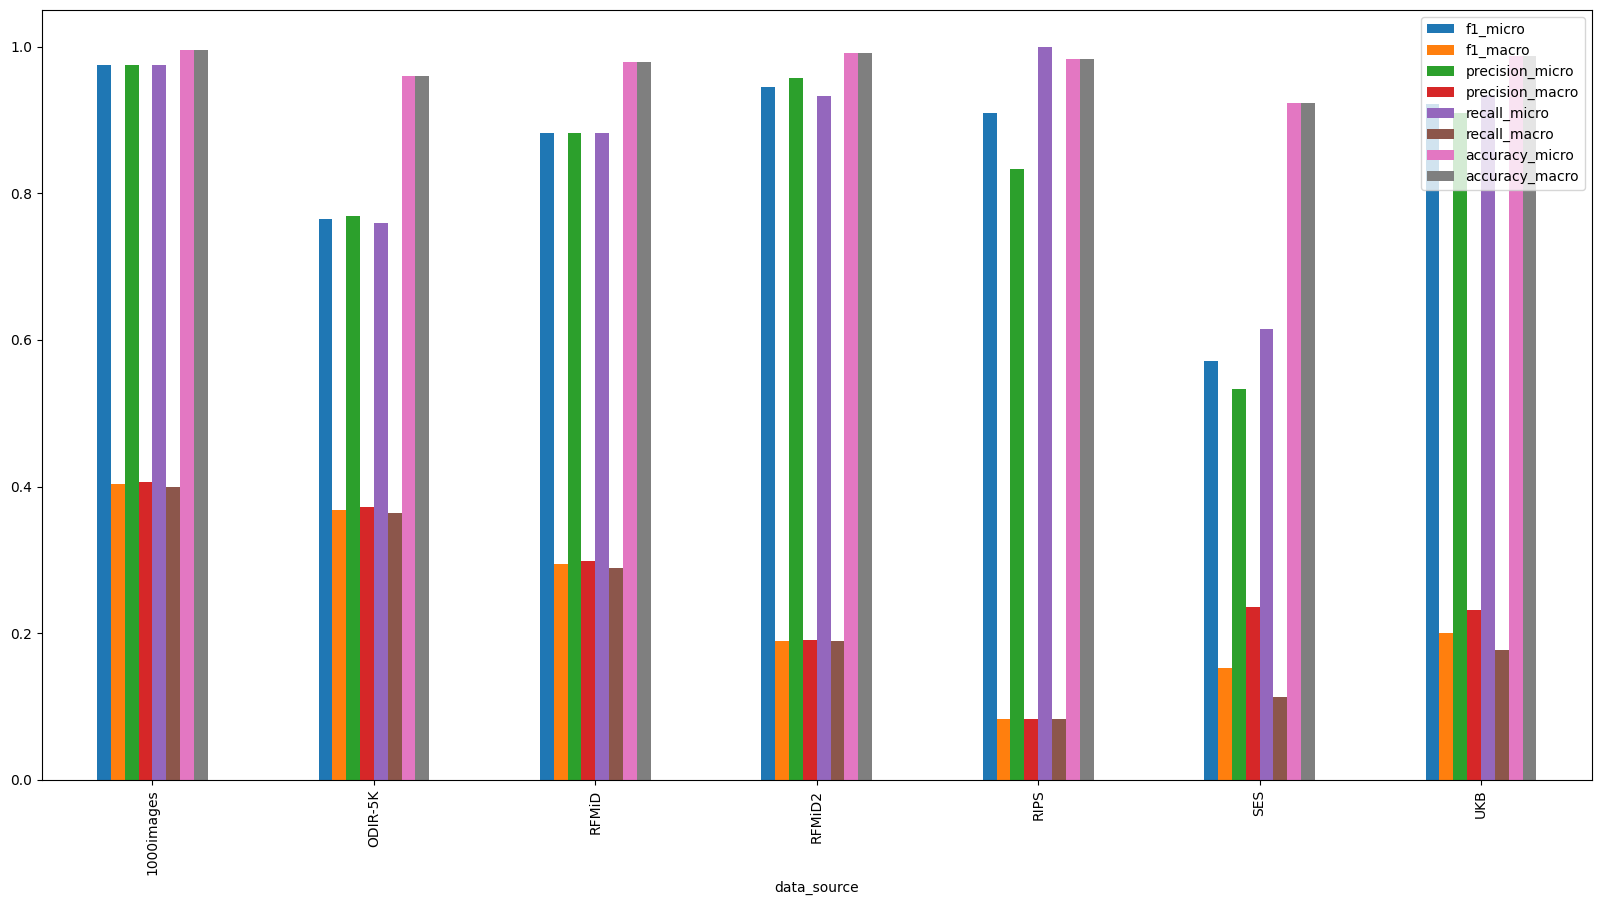

In [93]:
#create a pandas dataframe from the score dict
score_df = pd.DataFrame(score_dict)
#group the scores by data source
grouped_scores = score_df.groupby('data_source').mean()
#plot the grouped scores
grouped_scores.plot(kind='bar', figsize=(20, 10))
plt.savefig(f'{evaluations_save_folder}/grouped_scores.png')
plt.show()